# Counting pairs

In [9]:
import os
import pdb
import numpy as np
import astropy.io.fits as fits
from astropy.table import Table, unique
from MgIIabs.count import getdata 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [10]:
data_folder = os.environ['MGIIDATA']
MCdir = "MC data from G Ben Zhu/"
mcfiles = os.listdir(data_folder+MCdir)[:-1]
fullData = getdata.getObsData()

In [11]:
minREW = 1
truncData = fullData[fullData['REW_MGII_2796'] > minREW]

In [13]:
zmin = 0
zmax = float('inf')
fullData = Table.read(data_folder+'Trimmed_SDSS_DR7_107_NonBAL_NonRpt_SDSSRpt.fits')
fullData = fullData[fullData['BAL_FLG']==0]
fullData = fullData[(fullData['ZABS']>=zmin)*(fullData['ZABS']<=zmax)]
#Filtering out associated absorbers (<5000 km/s away)
fullData = fullData[abs(getdata._relVec(fullData['ZABS'],
                    fullData['ZQSO']))>(5000/3e5)]
truncData = fullData[fullData['REW_MGII_2796'] > minREW]
groupedData = truncData.group_by(['PLATE','FIBER','MJD'])
uniquePFMJD = groupedData.groups.keys

In [14]:
mctables = [fits.open(data_folder+MCdir+file, memmap=True)[1].data for file in mcfiles]

In [6]:
zgrid = getdata.getZgrid()
zrange = (zgrid>=zmin)*(zgrid<=zmax)

In [13]:
grouplengths = [len(group) for group in groupedData.groups]

In [26]:
grouplengths = groupedData.groups.indices[1:]-groupedData.groups.indices[:-1]

2

In [27]:
groupedData.groups[grouplengths>1]

RA,DEC,PLATE,FIBER,MJD,ZQSO,ERR_ZQSO,INDEX_QSO,SPEC_SNR_MEDIAN,MED_SDEVIATION_RED,MED_SDEVIATION_BLUE,NABS,ZABS,ERR_ZABS,VDISP,ERR_VDISP,CRITERION_MGII,CRITERION_MGII_FEII,CRITERION_FEII,SIGNAL_MGII_2803,SIGNAL_MGII_2796,SNR_MGII_2803,SNR_MGII_2796,REW_MGI_2853,ERR_REW_MGI_2853,REW_MGII_2803,ERR_REW_MGII_2803,REW_MGII_2796,ERR_REW_MGII_2796,REW_FEII_2600,ERR_REW_FEII_2600,REW_FEII_2586,ERR_REW_FEII_2586,REW_FEII_2383,ERR_REW_FEII_2383,REW_FEII_2374,ERR_REW_FEII_2374,REW_FEII_2344,ERR_REW_FEII_2344,VDISP_MGI_2853,ERR_VDISP_MGI_2853,VDISP_MGII_2803,ERR_VDISP_MGII_2803,VDISP_MGII_2796,ERR_VDISP_MGII_2796,VDISP_FEII_2600,ERR_VDISP_FEII_2600,VDISP_FEII_2586,ERR_VDISP_FEII_2586,VDISP_FEII_2383,ERR_VDISP_FEII_2383,VDISP_FEII_2374,ERR_VDISP_FEII_2374,VDISP_FEII_2344,ERR_VDISP_FEII_2344,BAL_FLG,KS_FLG,OK_FLG,EW [40],SIGEW [40],WREST,EWFLG,REPEAT_FLG
float32,float32,int16,int16,int32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,int16,int16,int32
147.554,-0.47753,267,264,51608,1.8916,0.002268,32013,7.11948,0.055562,0.0596509,2,1.67369,4.77607e-05,89.929,0.183242,1,1,1,3.29388,3.39441,15.5702,15.2565,0.729042,0.141121,2.64588,0.193085,2.77822,0.207678,2.65884,0.196716,2.32233,0.194292,2.41813,0.18929,1.92707,0.172979,2.01911,0.178602,0.06903,-0.0,89.7458,9.46543,90.1123,9.4754,100.15,9.93852,100.927,9.96615,95.3323,11.5533,95.8404,11.5726,77.2936,14.3554,0,1,1,0.0 .. 0.0,0.0 .. 0.0,2,1,0
147.554,-0.47753,267,264,51608,1.8916,0.002268,32013,7.11948,0.055562,0.0596509,2,1.78047,7.7529e-05,34.4297,0.221599,1,1,0,1.35261,1.92852,3.35369,6.9938,0.66823,0.337336,0.951048,0.269128,1.28395,0.201486,0.517051,0.139907,0.252457,0.128986,0.761731,0.17696,0.301528,0.176303,0.808007,0.272327,144.579,111.215,34.2081,27.6342,34.6513,27.421,16.9652,87.8865,18.4709,81.5748,120.744,41.7366,121.304,41.8351,245.709,105.321,0,1,1,0.0 .. 0.0,0.0 .. 0.0,1,1,0
154.15,0.147506,271,391,51883,2.30359,0.00192,-28430,17.7862,0.022049,0.0178304,2,1.41336,2.78659e-05,51.374,0.184795,1,1,1,1.34464,1.53008,18.4146,17.362,0.304629,0.0982625,0.995147,0.0618405,1.08722,0.0730617,0.880288,0.0871593,0.516151,0.0875266,0.923756,0.106397,0.379489,0.0967045,0.597726,0.0902302,83.24,52.9177,51.1892,8.43547,51.5588,8.41806,38.2317,17.6566,39.0821,17.4548,48.4625,18.9278,48.9744,18.8613,0.06903,9957.07,0,1,1,0.0 .. 0.0,0.0 .. 0.0,1,1,2
154.15,0.147506,271,391,51883,2.30359,0.00192,-28430,17.7862,0.022049,0.0178304,2,1.13673,1.33146e-05,85.3328,0.181008,1,1,0,1.65842,1.8483,17.0526,18.0738,0.178528,0.148062,1.33884,0.115412,1.50917,0.122157,0.332393,0.107774,0.079746,0.0940139,0.828057,0.173048,0.854008,0.16775,0.393759,0.223755,100.21,141.433,85.1517,10.7601,85.5138,10.7697,0.06903,24421.8,0.06903,24679.7,142.144,30.3944,142.758,30.4757,223.818,162.175,0,1,1,0.0 .. 0.0,0.0 .. 0.0,1,1,2
155.531,0.800132,271,603,51883,2.11045,0.002514,-27504,8.25319,0.0484033,0.0517319,4,0.988292,7.12014e-06,51.5366,0.184629,1,1,0,2.44774,2.41867,9.73048,11.0648,0.364089,0.217633,1.67957,0.233191,1.87243,0.225247,1.09615,0.190735,0.425208,0.176969,0.955471,0.257256,0.374156,0.235063,0.325162,0.172293,0.06903,22625.0,51.352,17.3426,51.7212,17.3073,0.06903,11254.4,0.06903,11373.2,34.9314,51.6482,35.527,51.1383,0.06903,-0.0,0,0,1,0.0 .. 0.0,0.0 .. 0.0,1,1,0
155.531,0.800132,271,603,51883,2.11045,0.002514,-27504,8.25319,0.0484033,0.0517319,4,1.85938,3.5838e-05,0.06903,0.0,1,0,0,2.07572,1.96114,8.2483,4.75349,0.359746,0.259938,1.34445,0.174237,1.04144,0.268475,0.163024,0.0861104,0.0517462,0.102348,0.104579,0.0735152,0.151028,0.0800287,0.140614,0.0981532,151.692,152.518,0.06903,5355.87,0.06903,5383.41,0.06903,-0.0,0.06903,-0.0,0.06903,

In [31]:
from itertools import combinations as combos
from itertools import chain

pairs = []
for group in groupedData.groups:
    zlist = group['ZABS']
    if len(zlist)>1:
        pairs += list(combos(zlist,2))
        pdb.set_trace()

> <ipython-input-31-68da3eb422d3>(5)<module>()
-> for group in groupedData.groups:
(Pdb) pairs
[(1.6736912, 1.7804674)]
(Pdb) c
> <ipython-input-31-68da3eb422d3>(5)<module>()
-> for group in groupedData.groups:
(Pdb) pairs
[(1.6736912, 1.7804674), (1.4133555, 1.1367333)]
(Pdb) c
> <ipython-input-31-68da3eb422d3>(5)<module>()
-> for group in groupedData.groups:
(Pdb) pairs
[(1.6736912, 1.7804674), (1.4133555, 1.1367333), (0.98829216, 1.8593823)]
(Pdb) c
> <ipython-input-31-68da3eb422d3>(5)<module>()
-> for group in groupedData.groups:
(Pdb) pairs
[(1.6736912, 1.7804674), (1.4133555, 1.1367333), (0.98829216, 1.8593823), (1.504118, 0.94414639), (1.504118, 1.9584594), (0.94414639, 1.9584594)]
(Pdb) q


BdbQuit: 

In [14]:
import cProfile, pstats, io
pr = cProfile.Profile()
pr.enable()

#final_list = Table(names=('zabs','cover','rewgrid'),dtype=(list,list,list))
final_list = []

for pfmjd, group in zip(uniquePFMJD,groupedData):
    for tab in mctables:
        temp = tab[tab['PLATE']==pfmjd[0]]
        temp = temp[temp['FIBER']==pfmjd[1]]
        if len(temp)==0:
            continue
        else:
            final_list.append([group['ZABS'],temp[0][2][zrange],temp[0][3][zrange]])
            break
pr.disable()
s = io.StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

KeyboardInterrupt: 

In [17]:
t=Table(names=('zabs','cover'),dtype=(list,list))
#help(Table.add_row)
t.add_row([[1,1],[1,1]])

In [77]:
del final_list

In [ ]:
zlist = [group['ZABS'].data for group in groupedData.groups]

In [94]:
groupedData.groups[0]['ZABS'].data

array([ 1.38195205], dtype=float32)

In [9]:
temp = mctables[0]
temp.columns

ColDefs(
    name = 'PLATE'; format = 'J'
    name = 'FIBER'; format = 'J'
    name = 'ISITCOVERED'; format = '7835B'
    name = 'REWMIN_MGII_2796'; format = '7835E'
    name = 'REWMIN_MGII_2803'; format = '7835E'
)

In [34]:
a = [(1,1.2),(2,3.2),(2,3.2)]
np.array(a)[:,0]

array([ 1.,  2.,  2.])

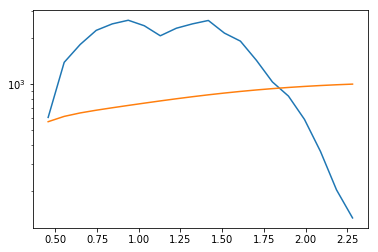

In [7]:
minREW = 0.3
func = lambda z,A: A*getdata._dNdz(z,minREW)
fulldata = getdata.getObsData()
fulldata = fulldata[fulldata['REW_MGII_2796'] > minREW]
zgrid = getdata._getzgrid()
hist = np.histogram(fulldata['ZABS'],20)
plt.semilogy(hist[1][1:],hist[0],hist[1][1:],func(hist[1][1:],1000))
plt.show()

In [21]:
plt.hist(mctables[0]['REWMIN_MGII_2796'])
plt.show()

KeyboardInterrupt: 